<img src="imgs/keras-logo-small.jpg" width="20%" />

## Keras: The Deep Learning library _for perfectionist, with deadlines_ $^1$

_`[1]`: Freely borrowed by the [Django](https://www.djangoproject.com) payoff_

**excerpt** from the officila documentation ([http://keras.io](http://keras.io))

>Keras is a high-level neural networks API, written in Python and capable of running on top of [TensorFlow](https://github.com/tensorflow/tensorflow), [CNTK](https://github.com/Microsoft/cntk), or [Theano](https://github.com/Theano/Theano). It was developed with a focus on enabling fast experimentation. 
>
> _Being able to go from idea to result with the least possible delay is key to doing good research._
>
> Use Keras if you need a deep learning library that:
> 
> * Allows for easy and fast prototyping (through user friendliness, modularity, and extensibility).
> * Supports both convolutional networks and recurrent networks, as well as combinations of the two.
> * Runs seamlessly on CPU and GPU.
>
>
> Keras is compatible with: **Python 2.7-3.5**.


<a name="kaggle"></a>
### Kaggle Challenge Data

>The Otto Group is one of the world’s biggest e-commerce companies, A consistent analysis of the performance of products is crucial. 
>
>However, due to diverse global infrastructure, many identical products get classified differently.
>
> For this competition, we have provided a dataset with 93 features for more than 200,000 products. The objective is to build a predictive model which is able to distinguish between our main product categories.
>
>Each row corresponds to a single product. There are a total of 93 numerical features, which represent counts of different events. All features have been obfuscated and will not be defined any further.

https://www.kaggle.com/c/otto-group-product-classification-challenge/data

##### For this section we will use the Kaggle Otto Group Challenge Data. You will find these data in 
`data/kaggle_ottogroup/` folder.

## Logistic Regression

This algorithm has nothing to do with the canonical _linear regression_, but it is an algorithm that allows us to solve problems of classification (supervised learning). 

In fact, to estimate the dependent variable, now we make use of the so-called **logistic function** or **sigmoid**. 

It is precisely because of this feature we call this algorithm logistic regression.

![](imgs/sigmoid.png)

## Data Preparation

In [1]:
from kaggle_data import load_data, preprocess_data, preprocess_labels
import numpy as np
import matplotlib.pyplot as plt

/home/reut/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
X_train, labels = load_data('data/kaggle_ottogroup/train.csv', train=True)
X_train, scaler = preprocess_data(X_train)
Y_train, encoder = preprocess_labels(labels)

X_test, ids = load_data('data/kaggle_ottogroup/test.csv', train=False)
X_test, _ = preprocess_data(X_test, scaler)

nb_classes = Y_train.shape[1]
print(nb_classes, 'classes')

dims = X_train.shape[1]
print(dims, 'features')

9 classes
93 features


In [3]:
np.unique(labels)

array(['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9'], dtype=object)

In [4]:
Y_train  # one-hot encoding

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

---

## Using Theano

import theano as th
import theano.tensor as T

#Based on example from DeepLearning.net
rng = np.random
N = 400
feats = 93
training_steps = 10

# Declare Theano symbolic variables
x = T.matrix("x")
y = T.vector("y")
w = th.shared(rng.randn(feats), name="w")
b = th.shared(0., name="b")

# Construct Theano expression graph
p_1 = 1 / (1 + T.exp(-T.dot(x, w) - b))         # Probability that target = 1
prediction = p_1 > 0.5                          # The prediction thresholded
xent = -y * T.log(p_1) - (1-y) * T.log(1-p_1)   # Cross-entropy loss function
cost = xent.mean() + 0.01 * (w ** 2).sum()      # The cost to minimize
gw, gb = T.grad(cost, [w, b])                   # Compute the gradient of the cost
                                                

# Compile
train = th.function(
          inputs=[x,y],
          outputs=[prediction, xent],
          updates=((w, w - 0.1 * gw), (b, b - 0.1 * gb)),
          allow_input_downcast=True)

predict = th.function(inputs=[x], outputs=prediction, allow_input_downcast=True)

#Transform for class1
y_class1 = []
for i in Y_train:
    y_class1.append(i[0])
y_class1 = np.array(y_class1)

# Train
for i in range(training_steps):
    print('Epoch %s' % (i+1,))
    pred, err = train(X_train, y_class1)

print("target values for Data:")
print(y_class1)
print("prediction on training set:")
print(predict(X_train))

---

## Using Tensorflow

In [5]:
import tensorflow as tf

In [6]:
# Parameters
learning_rate = 0.01
training_epochs = 25
display_step = 1

In [7]:
# tf Graph Input
x = tf.placeholder("float", [None, dims]) 
y = tf.placeholder("float", [None, nb_classes])

In [8]:
x

<tf.Tensor 'Placeholder:0' shape=(?, 93) dtype=float32>

### Model (Introducing Tensorboard)

In [9]:
# Construct (linear) model
with tf.name_scope("model") as scope:
    # Set model weights
    W = tf.Variable(tf.zeros([dims, nb_classes]))
    b = tf.Variable(tf.zeros([nb_classes]))
    activation = tf.nn.softmax(tf.matmul(x, W) + b) # Softmax

    # Add summary ops to collect data
    w_h = tf.summary.histogram("weights_histogram", W)
    b_h = tf.summary.histogram("biases_histograms", b)
    tf.summary.scalar('mean_weights', tf.reduce_mean(W))
    tf.summary.scalar('mean_bias', tf.reduce_mean(b))

# Minimize error using cross entropy
# Note: More name scopes will clean up graph representation
with tf.name_scope("cost_function") as scope:
    cross_entropy = y*tf.log(activation)
    cost = tf.reduce_mean(-tf.reduce_sum(cross_entropy,reduction_indices=1))
    # Create a summary to monitor the cost function
    tf.summary.scalar("cost_function", cost)
    tf.summary.histogram("cost_histogram", cost)

with tf.name_scope("train") as scope:
    # Set the Optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

### Accuracy

In [10]:
with tf.name_scope('Accuracy') as scope:
    correct_prediction = tf.equal(tf.argmax(activation, 1), tf.argmax(y, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    # Create a summary to monitor the cost function
    tf.summary.scalar("accuracy", accuracy)

### Learning in a TF Session

In [11]:
LOGDIR = "/tmp/logistic_logs"
import os, shutil
if os.path.isdir(LOGDIR):
    print("reut")
    shutil.rmtree(LOGDIR)
os.mkdir(LOGDIR)

# Plug TensorBoard Visualisation 
writer = tf.summary.FileWriter(LOGDIR, graph=tf.get_default_graph())

reut


In [12]:
for var in tf.get_collection(tf.GraphKeys.SUMMARIES):
    print(var.name)
    
summary_op = tf.summary.merge_all()
print('Summary Op: ' + summary_op)

model/weights_histogram:0
model/biases_histograms:0
model/mean_weights:0
model/mean_bias:0
cost_function/cost_function:0
cost_function/cost_histogram:0
Accuracy/accuracy:0
Tensor("add:0", shape=(), dtype=string)


accuracy epoch 0:0.6649535894393921
accuracy epoch 1:0.665276825428009
accuracy epoch 2:0.6657131910324097
accuracy epoch 3:0.6659556031227112
accuracy epoch 4:0.6662949919700623
accuracy epoch 5:0.6666020154953003
accuracy epoch 6:0.6668121218681335
accuracy epoch 7:0.6671029925346375
accuracy epoch 8:0.6674585342407227
accuracy epoch 9:0.667830228805542
accuracy epoch 10:0.6680887937545776
accuracy epoch 11:0.6682342886924744
accuracy epoch 12:0.6684605479240417
accuracy epoch 13:0.6687514185905457
accuracy epoch 14:0.6690422892570496
accuracy epoch 15:0.6692523956298828
accuracy epoch 16:0.6695109605789185
accuracy epoch 17:0.6697695255279541
accuracy epoch 18:0.6699796319007874
accuracy epoch 19:0.6702058911323547
accuracy epoch 20:0.6705452799797058
accuracy epoch 21:0.6708361506462097
accuracy epoch 22:0.6710785627365112
accuracy epoch 23:0.671385645866394
accuracy epoch 24:0.6716926693916321
Training phase finished


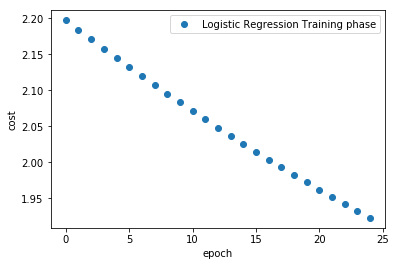

[1 5 5 ... 2 1 1]


In [13]:
# Launch the graph
with tf.Session() as session:
    # Initializing the variables
    session.run(tf.global_variables_initializer())
    
    cost_epochs = []
    # Training cycle
    for epoch in range(training_epochs):
        _, summary, c = session.run(fetches=[optimizer, summary_op, cost], 
                                    feed_dict={x: X_train, y: Y_train})
        cost_epochs.append(c)
        writer.add_summary(summary=summary, global_step=epoch)
        print("accuracy epoch {}:{}".format(epoch, accuracy.eval({x: X_train, y: Y_train})))
        
    print("Training phase finished")
    
    #plotting
    plt.plot(range(len(cost_epochs)), cost_epochs, 'o', label='Logistic Regression Training phase')
    plt.ylabel('cost')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()
    
    prediction = tf.argmax(activation, 1)
    print(prediction.eval({x: X_test}))

In [14]:
%%bash
#python -m tensorflow.tensorboard --logdir=/tmp/logistic_logs
tensorboard --logdir='/tmp/logistic_logs'

Process is terminated.


---

# Using Keras

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Activation

In [16]:
dims = X_train.shape[1]
print(dims, 'dims')
print("Building model...")

nb_classes = Y_train.shape[1]
print(nb_classes, 'classes')

model = Sequential()
model.add(Dense(nb_classes, input_shape=(dims,), activation='sigmoid'))
model.add(Activation('softmax'))

model.compile(optimizer='sgd', loss='categorical_crossentropy')
model.fit(X_train, Y_train)

93 dims
Building model...
9 classes
Epoch 1/1
61878/61878 [==============================] - 3s 51us/step - loss: 2.0051


#### Simplicity is pretty impressive, right? :)

### Now lets understand:
- The core data structure of Keras is a <b>model</b>, a way to organize layers. 
- The main type of model is the <b>Sequential</b> model, a linear stack of layers.


What we did here is stacking a Fully Connected (<b>Dense</b>) layer of trainable weights from the input to the output and an <b>Activation</b> layer on top of the weights layer.

##### Dense

```python
from keras.layers.core import Dense

Dense(units, activation=None, use_bias=True, 
      kernel_initializer='glorot_uniform', bias_initializer='zeros', 
      kernel_regularizer=None, bias_regularizer=None, 
      activity_regularizer=None, kernel_constraint=None, bias_constraint=None)
```

* `units`: int > 0.

* `kernel_initializer`: Initializer for the kernel weights matrix.

* `bias_initializer`: Initializer for the bias vector.

* `activation`: name of activation function to use. If you don't specify anything, no activation is applied (ie. "linear" activation: `a(x) = x`).

* `weights`: list of Numpy arrays to set as initial weights. The list should have 2 elements, of shape (input_dim, output_dim) and (output_dim,) for weights and biases respectively.

* `kernel_regularizer`: Regulariser function (eg. L1 or L2 regularization), applied to the `kernel` weights matrix.

* `bias_regularizer`: Regulariser function applied to the bias vector.

* `activity_regularizer`: Regularizer function applied to the output of the layer (its "activation").

* `kernel_constraint`: Constraint function applied to the main weights matrix.

* `bias_constraint`: Constraint function applied to the bias.

* `use_bias`: whether to include a bias (i.e. make the layer affine rather than linear).

### Input and Output Shapes

##### Input shape

`nD` tensor with shape: `(batch_size, ..., input_dim)`. The most common situation would be a 2D input with shape `(batch_size, input_dim)`.

##### Output shape

`nD` tensor with shape: `(batch_size, ..., units)`. For instance, for a 2D input with shape `(batch_size, input_dim)`, the output would have shape `(batch_size, units)`.

### Notes about `*_initializers`

Weight initialization can critically affect the speed at which a neural network is able to learn. Under certain circumstances, a poor initialization of weights can prevent a neural network from learning anything.

For further details, please refer to this super interesting article from NVIDIA DIGITS: [Weights Initialisers](https://github.com/NVIDIA/DIGITS/blob/master/examples/weight-init/README.md)

Keras supports different initialisation strategies: [`keras.initializers`](https://keras.io/initializers/).


#### Some Recommended Papers:

[1] Bengio, Yoshua. ["Practical recommendations for gradient-based training of deep architectures."](http://arxiv.org/abs/1206.5533) Neural Networks: Tricks of the Trade. Springer Berlin Heidelberg, 2012. 437-478.

[2] LeCun, Y., Bottou, L., Orr, G. B., and Muller, K. (1998a). [Efficient backprop. In Neural Networks](https://scholar.google.com/scholar?cluster=1366432119558306638&hl=en&as_sdt=0,22), Tricks of the Trade.

[3] Glorot, Xavier, and Yoshua Bengio. ["Understanding the difficulty of training deep feedforward neural networks."](https://scholar.google.com/scholar?cluster=17889055433985220047&hl=en&as_sdt=0,22) International conference on artificial intelligence and statistics. 2010.

## (some) others `keras.core.layers`

* `keras.layers.core.Flatten()`
* `keras.layers.core.Reshape(target_shape)`
* `keras.layers.core.Permute(dims)`

```python
model = Sequential()
model.add(Permute((2, 1), input_shape=(10, 64)))
# now: model.output_shape == (None, 64, 10)
# note: `None` is the batch dimension
```

* `keras.layers.core.Lambda(function, output_shape=None, arguments=None)`
* `keras.layers.core.ActivityRegularization(l1=0.0, l2=0.0)`

<img src="imgs/dl_overview.png" >

Credits: Yam Peleg ([@Yampeleg](https://twitter.com/yampeleg))

### Activation

```python
from keras.layers.core import Activation

Activation(activation)
```

**Supported Activations** : [https://keras.io/activations/]

**Advanced Activations**: [https://keras.io/layers/advanced-activations/]

### Optimizer

If you need to, you can further configure your optimizer. A core principle of Keras is to make things reasonably simple, while allowing the user to be fully in control when they need to (the ultimate control being the easy extensibility of the source code).
Here we used <b>SGD</b> (stochastic gradient descent) as an optimization algorithm for our trainable weights.  

<img src="http://sebastianruder.com/content/images/2016/09/saddle_point_evaluation_optimizers.gif" width="40%">

Source & Reference: http://sebastianruder.com/content/images/2016/09/saddle_point_evaluation_optimizers.gif

"Data Sciencing" this example a little bit more
=====

What we did here is nice, however in the real world it is not useable because of overfitting.
Lets try and solve it with cross validation.

### Overfitting

In overfitting, a statistical model describes random error or noise instead of the underlying relationship. Overfitting occurs when a model is excessively complex, such as having too many parameters relative to the number of observations. 

A model that has been overfit has poor predictive performance, as it overreacts to minor fluctuations in the training data.


<img src="imgs/overfitting.png">

<pre>To avoid overfitting, we will first split out data to training set and test set and test out model on the test set.
Next: we will use two of keras's callbacks <b>EarlyStopping</b> and <b>ModelCheckpoint</b></pre>

---

Let's see first the model we implemented

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 9)                 846       
_________________________________________________________________
activation_1 (Activation)    (None, 9)                 0         
Total params: 846
Trainable params: 846
Non-trainable params: 0
_________________________________________________________________


In [18]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [19]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15, random_state=42)

fBestModel = 'best_model.h5' 
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1) 
best_model = ModelCheckpoint(fBestModel, verbose=0, save_best_only=True)

model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=50, 
          batch_size=128, verbose=True, callbacks=[best_model, early_stop]) 

Train on 52596 samples, validate on 9282 samples
Epoch 1/50
52596/52596 [==============================] - 1s 21us/step - loss: 1.8789 - val_loss: 1.8676
Epoch 2/50
52596/52596 [==============================] - 1s 16us/step - loss: 1.8585 - val_loss: 1.8492
Epoch 3/50
52596/52596 [==============================] - 1s 15us/step - loss: 1.8416 - val_loss: 1.8336
Epoch 4/50
52596/52596 [==============================] - 1s 14us/step - loss: 1.8272 - val_loss: 1.8201
Epoch 5/50
52596/52596 [==============================] - 1s 15us/step - loss: 1.8146 - val_loss: 1.8083
Epoch 6/50
52596/52596 [==============================] - 1s 15us/step - loss: 1.8034 - val_loss: 1.7977
Epoch 7/50
52596/52596 [==============================] - 1s 15us/step - loss: 1.7933 - val_loss: 1.7881
Epoch 8/50
52596/52596 [==============================] - 1s 15us/step - loss: 1.7842 - val_loss: 1.7794
Epoch 9/50
52596/52596 [==============================] - 1s 15us/step - loss: 1.7759 - val_loss: 1.7714
Epoch 

# Multi-Layer Fully Connected Networks

<img src="imgs/MLP.png" width="45%">

#### Forward and Backward Propagation

<img src="imgs/backprop.png" width="50%">

**Q:** _How hard can it be to build a Multi-Layer Fully-Connected Network with keras?_

**A:** _It is basically the same, just add more layers!_

In [20]:
model = Sequential()
model.add(Dense(100, input_shape=(dims,)))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
model.compile(optimizer='sgd', loss='categorical_crossentropy')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 100)               9400      
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 909       
_________________________________________________________________
activation_2 (Activation)    (None, 9)                 0         
Total params: 10,309
Trainable params: 10,309
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=20, 
          batch_size=128, verbose=True)

Train on 52596 samples, validate on 9282 samples
Epoch 1/20
52596/52596 [==============================] - 1s 21us/step - loss: 1.2028 - val_loss: 0.8682
Epoch 2/20
52596/52596 [==============================] - 1s 18us/step - loss: 0.8123 - val_loss: 0.7720
Epoch 3/20
52596/52596 [==============================] - 1s 18us/step - loss: 0.7529 - val_loss: 0.7339
Epoch 4/20
52596/52596 [==============================] - 1s 18us/step - loss: 0.7244 - val_loss: 0.7142
Epoch 5/20
52596/52596 [==============================] - 1s 18us/step - loss: 0.7067 - val_loss: 0.6997
Epoch 6/20
52596/52596 [==============================] - 1s 18us/step - loss: 0.6948 - val_loss: 0.6909
Epoch 7/20
52596/52596 [==============================] - 1s 17us/step - loss: 0.6860 - val_loss: 0.6838
Epoch 8/20
52596/52596 [==============================] - 1s 18us/step - loss: 0.6793 - val_loss: 0.6782
Epoch 9/20
52596/52596 [==============================] - 1s 18us/step - loss: 0.6741 - val_loss: 0.6741
Epoch 

---

# Your Turn!

## Hands On - Keras Fully Connected


Take couple of minutes and try to play with the number of layers and the number of parameters in the layers to get the best results. 

In [22]:
model = Sequential()
model.add(Dense(100, input_shape=(dims,)))
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(30))

# ...
# ...
# Play with it! add as much layers as you want! try and get better results.

model.add(Dense(nb_classes))
model.add(Activation('softmax'))
model.compile(optimizer='sgd', loss='categorical_crossentropy')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               9400      
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_7 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_8 (Dense)              (None, 9)                 279       
_________________________________________________________________
activation_3 (Activation)    (None, 9)                 0         
Total params: 26,359
Trainable params: 26,359
Non-trainable params: 0
_________________________________________________________________


In [23]:
fBestModel = 'best_model_reut.h5' 
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1) 
best_model = ModelCheckpoint(fBestModel, verbose=0, save_best_only=True)

model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=70, 
          batch_size=128, verbose=True, callbacks=[best_model, early_stop]) 

Train on 52596 samples, validate on 9282 samples
Epoch 1/70
52596/52596 [==============================] - 1s 28us/step - loss: 0.9855 - val_loss: 0.7652
Epoch 2/70
52596/52596 [==============================] - 1s 25us/step - loss: 0.7400 - val_loss: 0.7134
Epoch 3/70
52596/52596 [==============================] - 1s 26us/step - loss: 0.7040 - val_loss: 0.6928
Epoch 4/70
52596/52596 [==============================] - 1s 24us/step - loss: 0.6871 - val_loss: 0.6794
Epoch 5/70
52596/52596 [==============================] - 1s 24us/step - loss: 0.6757 - val_loss: 0.6723
Epoch 6/70
52596/52596 [==============================] - 1s 24us/step - loss: 0.6686 - val_loss: 0.6690
Epoch 7/70
52596/52596 [==============================] - 1s 24us/step - loss: 0.6627 - val_loss: 0.6647
Epoch 8/70
52596/52596 [==============================] - 1s 24us/step - loss: 0.6592 - val_loss: 0.6672
Epoch 9/70
52596/52596 [==============================] - 1s 24us/step - loss: 0.6568 - val_loss: 0.6580
Epoch 

Building a question answering system, an image classification model, a Neural Turing Machine, a word2vec embedder or any other model is just as fast. The ideas behind deep learning are simple, so why should their implementation be painful?

#### Theoretical Motivations for depth

>Much has been studied about the depth of neural nets. Is has been proven mathematically[1] and empirically that convolutional neural network benifit from depth! 

[1] - On the Expressive Power of Deep Learning: A Tensor Analysis - Cohen, et al 2015

#### Theoretical Motivations for depth

One much quoted theorem about neural network states that:

>Universal approximation theorem states[1] that a feed-forward network with a single hidden layer containing a finite number of neurons (i.e., a multilayer perceptron), can approximate continuous functions on compact subsets of $\mathbb{R}^n$, under mild assumptions on the activation function. The theorem thus states that simple neural networks can represent a wide variety of interesting functions when given appropriate parameters; however, it does not touch upon the algorithmic learnability of those parameters.

[1] - Approximation Capabilities of Multilayer Feedforward Networks - Kurt Hornik 1991

## Addendum

[1.1 Keras Backend](1.1  Keras Backend.ipynb)